# ACNets resting-state fMRI
## Functional connectivity feature extraction

Resting-state preprocessing results in five kinds of individual-level functional connectivity matrices, $W\text{s}$, each of size $32\times39\times39$, where $W_{ijk}$ is the connectivity between the time-series of nodes $j$ and $k$ in the control network of the subject $i$.

The connectivity matrices are symmetric, so we only need to keep the upper triangular part of the matrix. This results in a (32, 780) matrix, where each columns is a connectivity measure between two nodes.

## Setup

In [273]:

import numpy as np
import xarray as xr
import pandas as pd

from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns; sns.set('talk')
import plotly.express as px

from sklearn import preprocessing, model_selection, metrics, ensemble, multioutput
from sklearn import decomposition, cross_decomposition, feature_selection
from sklearn.pipeline import Pipeline
# from xgboost import XGBClassifier  # incompatible with umap's scipy

from umap import UMAP

# Technical reproducibility
%reload_ext watermark
%watermark -iv -co -ituhmv

Last updated: 2022-02-09T18:19:17.615528+01:00

Python implementation: CPython
Python version       : 3.9.10
IPython version      : 8.0.1

conda environment: acnets

Compiler    : Clang 11.1.0 
OS          : Darwin
Release     : 21.3.0
Machine     : x86_64
Processor   : i386
CPU cores   : 12
Architecture: 64bit

Hostname: MP0159

matplotlib: 3.5.1
sys       : 3.9.10 | packaged by conda-forge | (main, Feb  1 2022, 21:28:27) 
[Clang 11.1.0 ]
numpy     : 1.21.5
seaborn   : 0.11.2
sklearn   : 1.0.2
pandas    : 1.4.0
plotly    : 5.5.0
xarray    : 0.21.1



## Data

In [274]:
# 1. load the connectivity dataset
DATASET = xr.open_dataset('data/julia2018_resting/connectivity.nc').load()

# 2. input (connectivities)
X = np.array(
  [subj_conn[np.triu_indices_from(subj_conn, k=0)] 
   for subj_conn in DATASET['partial_correlation_connectivity'].values]
  )

# 2. classifier output (AVGP or NVGP)
y_encoder = preprocessing.LabelEncoder()
y = y_encoder.fit_transform(DATASET['group'])

# 3. behavioral outputs (inverse efficiency scores in millis)
y_beh = DATASET['inverse_efficiency_score_ms'].values

# 4.1. remove subjects with missing behavioral data
valid_beh_subjects_mask = ~np.isnan(y_beh)

# 4.2. remove subjects with two resting-state sessions (keep only the one suffixed by a "NEW")
_subj_labels = xr.concat([DATASET['subject'], DATASET['subject'] + 'NEW'], dim='subject')
valid_resting_subjects_mask = ~_subj_labels.to_series().duplicated(keep='first')[34:].values

valid_subjects_mask = valid_resting_subjects_mask & valid_beh_subjects_mask

# 4.3. now filter out subjects with missing behavioral data or repeated resting-state sessions
subjects = DATASET['subject'][valid_subjects_mask]
X = X[valid_subjects_mask]
y = y[valid_subjects_mask]
y_beh = y_beh[valid_subjects_mask]

# 5. Feature extraction
# X_thresholds = np.median(X, axis=1) + np.std(X, axis=1)
# X_binarized = np.where(np.abs(X) < X_thresholds.reshape(-1,1), 0., 1.)
# X_reduced = UMAP(n_neighbors=15, n_components=2).fit_transform(X)

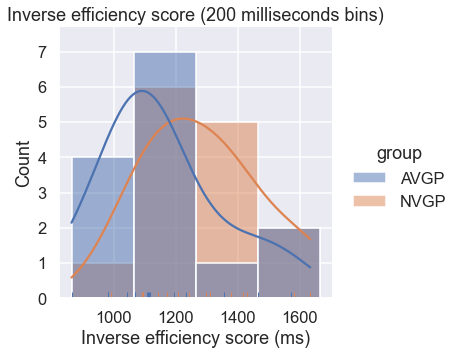

In [275]:
g = sns.displot(
  data = DATASET[['group','inverse_efficiency_score_ms']].to_dataframe()[valid_subjects_mask],
  x='inverse_efficiency_score_ms', hue='group',
  binwidth=200,
  kde=True,rug=True,
)

g.set(title='Inverse efficiency score (200 milliseconds bins)',
      xlabel='Inverse efficiency score (ms)',)
plt.show()

In [276]:
# DEBUG: plot dimensionality-reduced inputs, colored by outputs


def transform(X, y, y_beh, select_k=10, embedding_dim=2):

  selector = feature_selection.SelectKBest(feature_selection.f_regression, k=select_k)
  selector = feature_selection.SelectKBest(feature_selection.f_classif, k=select_k)
  reducer = cross_decomposition.PLSRegression(n_components=embedding_dim)
  # reducer = UMAP(n_neighbors=3, n_components=embedding_dim)
  # reducer = decomposition.PCA(n_components=embedding_dim)

  # 1. remove zero-variance features, 2. select top features, 3. reduce features
  X_transformed = feature_selection.VarianceThreshold(threshold=0).fit_transform(X)
  X_transformed = selector.fit_transform(X_transformed, y)
  X_transformed, _ = reducer.fit_transform(X_transformed, y_beh)
  # X_transformed = reducer.fit_transform(X_transformed, y_beh)
  # X_transformed = reducer.fit_transform(X_transformed)
  
  return X_transformed, selector, reducer


# 3. fit the model

subjs_train, subjs_test, X_train, X_test, y_train, y_test, y_beh_train, y_beh_test = (
  model_selection.train_test_split(subjects, X, y, y_beh, test_size=0.5))

X_transformed,selector,reducer = transform(X_train, y_train, y_beh_train, embedding_dim=3)


# plot
plotting_data = pd.DataFrame(X_transformed)
plotting_data['group'] = y_encoder.inverse_transform(y_train)
plotting_data['subject'] = subjs_train

if X_transformed.shape[1] == 2:
  # 2D
  g = sns.scatterplot(data=plotting_data, x=0, y=1, hue='group')
  g.set(xlabel='dim1', ylabel='dim2',
        title='Guided embedding of the connectivity matrix.\nPoints are subjects.')
  plt.show()
else:
  # 3D plot
  fig = px.scatter_3d(
    plotting_data,
    x=0, y=1, z=2, color='group', hover_name='subject',
    title='Embedding of the upper triangle connectivity matrices. Points are subjects.')

  fig.show()

In [277]:
# now use the fitted model to transform the test data

X_test_transformed = feature_selection.VarianceThreshold(threshold=0).fit_transform(X_test)
X_test_transformed = selector.transform(X_test_transformed)
X_test_transformed = reducer.transform(X_test_transformed)

# plot
plotting_data = pd.DataFrame(X_test_transformed)
plotting_data['group'] = y_encoder.inverse_transform(y_test)
plotting_data['subject'] = subjs_test

if X_test_transformed.shape[1] == 2:
  # 2D
  g = sns.scatterplot(data=plotting_data, x=0, y=1, hue='group')
  g.set(xlabel='dim1', ylabel='dim2',
        title='Test set embedding.\nPoints are subjects.')
  plt.show()
else:
  # 3D plot
  fig = px.scatter_3d(
    plotting_data,
    x=0, y=1, z=2, color='group', hover_name='subject',
    title='Test set embedding. Points are subjects.')

  fig.show()